In [1]:
# import standard python library
import pyodbc
import pandas as pd
import numpy as np
import joblib
from pandasql import sqldf
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

# import PDM library
from ut_connection_lib import Connection, Query
from feature_derivator import engine_hd785_feature_derivator
from pmm_tools_function import *
from pmm_transformers_library import \
    VHMSReplaceSensorErrorValue, DeriveFeatures, DfMapMinMaxScaler, DfStandardScaler, FeaturesSelector, \
    RemoveByThreshold, InverseTransfromStandardScaller, HealthScoreModelRouter, PapOilImputation, PapOilDataCleanser,\
    EnsureDataTypes

# import scikit learn modules
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pd.options.mode.chained_assignment = None  # default='warn'

## Get Data From Database

Activate 3 cells bellow to read data from database

prod_connection = Connection(dbname="PROD")
dev_connection = Connection(dbname="DEVELOPMENT")

unit_population_history_query = Query(source_file="sql_query/sql_query_unit_population_history.txt")
unit_population_latest_query = Query(source_file="sql_query/sql_query_unit_population_latest.txt")
vhms_trend_hd785_query = Query(source_file="sql_query/sql_query_vhms_trend_hd785.txt")
vhms_fault_hd785_query = Query(source_file="sql_query/sql_query_vhms_fault_hd785.txt")
vhms_chastrend_hd785_query = Query(source_file="sql_query/sql_query_chastrend_hd785.txt")
pap_oil_query = Query(source_file="sql_query/sql_query_pap_oil.txt")

unit_population_history = unit_population_history_query.execute(prod_connection)
unit_population_latest = unit_population_latest_query.execute(prod_connection)
vhms_trend_hd785 = vhms_trend_hd785_query.execute(prod_connection)
vhms_chastrend_hd785 = vhms_chastrend_hd785_query.execute(prod_connection)
pap_oil = pap_oil_query.execute(prod_connection)

## Get Data From Local File
activate cell bellow to read data from local file

In [2]:
print("Start ",mark_timestamp())

unit_population_latest = pd.read_excel('local_data/unit_population_latest.xlsx')
print("Unit population ",mark_timestamp())

hist_comp_repl = pd.read_excel('local_data/historical_component_replacement.xlsx')
print("Historical Component ",mark_timestamp())

vhms_fault_hd785 = pd.read_excel('local_data/vhms_fault_hd785.xlsx')
print("VHMS Fault ",mark_timestamp())

pap_oil = pd.read_excel('local_data/pap_oil.xlsx')
print("PAP Oil ",mark_timestamp())

vhms_trend_hd785 = pd.read_excel('local_data/vhms_trend_hd785.xlsx')
print("VHMS Trend ",mark_timestamp())

Start  2019-09-10 10:07:03
Unit population  2019-09-10 10:07:04
Historical Component  2019-09-10 10:07:04
VHMS Fault  2019-09-10 10:09:06
PAP Oil  2019-09-10 10:10:40
VHMS Trend  2019-09-10 10:16:10


In [3]:
unit_population_latest = pd.read_excel('local_data/unit_population_latest.xlsx')
print("Unit population ",mark_timestamp())


Unit population  2019-09-10 10:16:11


# VHMS Data Processing As Primary Data

In [4]:
# Select VHMS records that meet criteria

vhms_completeness_report = pd.read_excel("vhms_completeness_report_hd785.xlsx")
srl_num_passed = vhms_completeness_report[
    (vhms_completeness_report['COMPLETENESS']<2) & # ensure no duplication
    (vhms_completeness_report['COUNT']>=500) & # ensure data size
    (vhms_completeness_report['COMPLETENESS']>=0.75) # ensure data completeness
]['MCHN_SRL_NUM'].drop_duplicates().tolist()

# Select VHMS that match criteria
vhms_trend_hd785_selected = vhms_trend_hd785[
    (vhms_trend_hd785["UNIT_SRL_NUM"].isin(srl_num_passed)) &
    (vhms_trend_hd785["COOL_TEMP_MX"]>30) &
    (vhms_trend_hd785["TRAVELSPEED_MX"]>0) &
    (vhms_trend_hd785["ENG_SPEED_MX"]>0)
].reset_index(drop=True)
vhms_trend_hd785_selected['UNIT_SRL_NUM'] = vhms_trend_hd785_selected['UNIT_SRL_NUM'].astype(str)
vhms_trend_hd785_selected['UNIT_MODL'] = 'HD785-7'

print("Number of units: {}".format(len(srl_num_passed)))
print("Number of records: {}".format(len(vhms_trend_hd785_selected)))

Number of units: 481
Number of records: 535708


# Initialize preprocessing Pipeline

In [5]:
vhms_params = read_from_file("parameters/engine_hd785_vhms_params.txt")
vhms_param_name = np.array([s.split(", ")[0] for s in vhms_params])
vhms_param_source = np.array([s.split(", ")[1] for s in vhms_params])
vhms_param_used = np.array([s.split(", ")[2] for s in vhms_params])
primary_features = list(vhms_param_name[np.where(vhms_param_source=='PRIMARY')])
final_features = list(vhms_param_name[np.where(vhms_param_used=='TRUE')])
z_score_anomaly_thres = [(-3,3 )]*len(final_features+primary_features)

# VHMS Healthy Sample

Health VHMS sample comes from 2 sources. Early SMR between 500 to 1000 hours and early SMR of later engine replacement

In [6]:
standard_scaler_early_data = DfStandardScaler(final_features+primary_features)
vhms_early_cleaning_pipe = Pipeline([
    ('sensor-error-handling', VHMSReplaceSensorErrorValue(primary_features)),
    ('features-derivator', DeriveFeatures([engine_hd785_feature_derivator])), 
    ('standard-scaler', standard_scaler_early_data),
    ('anomaly-removal', RemoveByThreshold(primary_features, z_score_anomaly_thres)),
    ('inverse-standard-scaller', InverseTransfromStandardScaller(standard_scaler_early_data))
])

## VHMS Healthy Sample from Vehicle Early Life

In [7]:
vhms_hd785_early_vehicle = vhms_trend_hd785_selected[(vhms_trend_hd785_selected['SMR']<1200) & 
                                             (vhms_trend_hd785_selected['SMR']>500)]
vhms_hd785_early_vehicle['TIMESTAMP'] = vhms_hd785_early_vehicle['TIMESTAMP'].map(lambda x: str(x)[:19])
vhms_hd785_early_vehicle['failure'] = 0

## VHMS Healthy Sample from Component Early Life

In [8]:
engine_replacement = hist_comp_repl[
    (hist_comp_repl['MODL_UNIT']=='HD785-7') &
    (hist_comp_repl['COMPONENT']=='ENGINE ASSY') & 
    (hist_comp_repl['LIFETIME_HOUR']>=18000)][['SRL_NUM', 'BEG_HM']]
engine_replacement.columns = ['UNIT_SRL_NUM', 'BEGIN_SMR']
vhms_hd785_early_component = pd.merge(
    vhms_trend_hd785_selected, engine_replacement, how='inner', on='UNIT_SRL_NUM')
vhms_hd785_early_component['RESET_SMR'] = \
    vhms_hd785_early_component['SMR'] - vhms_hd785_early_component['BEGIN_SMR']
vhms_hd785_early_component = vhms_hd785_early_component[
    (vhms_hd785_early_component['RESET_SMR']>=500) & 
    (vhms_hd785_early_component['RESET_SMR']<=1500)].\
    drop(['BEGIN_SMR', 'RESET_SMR'], 1)
vhms_hd785_early_component['TIMESTAMP'] = vhms_hd785_early_component['TIMESTAMP'].map(lambda x: str(x)[:19])
vhms_hd785_early_component['failure'] = 0

### Join both Healthy Dataset

In [9]:
vhms_hd785_early = reduce_by_key(
    pd.concat([vhms_hd785_early_vehicle, vhms_hd785_early_component]),
    group_key = ['UNIT_SRL_NUM', 'TIMESTAMP'],
    sort_key = ['failure'])
print(len(vhms_hd785_early_vehicle))
print(len(vhms_hd785_early_component))
print(len(vhms_hd785_early))

10396
1932
10976


In [10]:
vhms_hd785_early_transformed = vhms_early_cleaning_pipe.fit_transform(vhms_hd785_early.copy())

2019-09-10 10:16:12: Fitting sensor error scaler with data
	2019-09-10 10:16:12: Separate sensor value from mean calculation
	2019-09-10 10:16:12: Computing average value of each equipment
	2019-09-10 10:16:13: Computing average value of all equipment
	2019-09-10 10:16:13: Finish fitting scaler
2019-09-10 10:16:13: Transforming data
	2019-09-10 10:16:13: Replacing error value with average for each serial number


### Some equipments are discarded due to abnormality in early lifetime 

In [11]:
unit_discarded = vhms_hd785_early[
    ~vhms_hd785_early['UNIT_SRL_NUM'].isin(vhms_hd785_early_transformed['UNIT_SRL_NUM'].tolist())
]['UNIT_SRL_NUM'].drop_duplicates().tolist()

discarded_units = unit_population_latest[
    unit_population_latest['SRL_NUM'].isin(unit_discarded)].sort_values('SRL_NUM').reset_index(drop=True)
discarded_units

,SRL_NUM,MODL_NUM,ROOM,PLNT,SORT_FLD,CUSTOMER_NAME,CONTRACT,LAST_UPDATED_DATE
0,30183,HD785-7,HD1143,BKJ,NaN,SIMS JAYA KALTIM,FMC,2014-06-13
1,7436,HD785-7,DT3293,BNT,NaN,PAMAPERSADA NUSANTARA,NON-FMC,2011-12-20
2,7914,HD785-7,NaN,ADR,ADARO,PAMAPERSADA NUSANTARA,NON-FMC,2014-05-12


## Discover Degrading VHMS as Failure Example

In [12]:
# VHMS failure from component replacement (late SMR)

sch_replacement = hist_comp_repl[(hist_comp_repl['MODL_UNIT']=='HD785-7') &  
                                 (hist_comp_repl['COMPONENT']=='ENGINE ASSY') & 
                                 (hist_comp_repl['LIFETIME_HOUR']>=20000) &
                                 (hist_comp_repl['STATUS']=='SCH')][['SRL_NUM', 'STATUS', 'END_HM', 'LIFETIME_HOUR']]
sch_replacement['RUN_TO_FAILURE'] = sch_replacement['LIFETIME_HOUR'].apply(lambda x: 0.01*x if x<=25000 else 0.01*25000)

usc_replacement = hist_comp_repl[(hist_comp_repl['MODL_UNIT']=='HD785-7') &  
                                 (hist_comp_repl['COMPONENT']=='ENGINE ASSY') & 
                                 (hist_comp_repl['STATUS']=='USC')][['SRL_NUM', 'STATUS', 'END_HM', 'LIFETIME_HOUR']]
usc_replacement['RUN_TO_FAILURE'] = 500

engine_replacement = pd.concat([sch_replacement, usc_replacement])
engine_replacement.columns = ['UNIT_SRL_NUM', 'STATUS', 'END_HM', 'LIFETIME', 'RUN_TO_FAILURE']

vhms_from_replacement = pd.merge(engine_replacement, vhms_trend_hd785_selected, how='inner', on='UNIT_SRL_NUM')
vhms_from_replacement = \
    vhms_from_replacement[
        (vhms_from_replacement['SMR'] > vhms_from_replacement['END_HM']-vhms_from_replacement['RUN_TO_FAILURE']) & 
        (vhms_from_replacement['SMR'] <= vhms_from_replacement['END_HM'])][vhms_trend_hd785.columns]
vhms_from_replacement['UNIT_MODL'] = 'HD785-7'

In [13]:
def label_vhms_from_fault(vhms_trend, vhms_fault, fault_code, minimum_duration):
    vhms_fault_specific = vhms_fault[(vhms_fault['CODE']==fault_code) & 
                                   (vhms_fault['TOTAL_DURATION_MINUTES'] >= minimum_duration)].copy()
    vhms_fault_specific['NUM_DAYS'] = \
        (vhms_fault_specific['TO_DATE'].astype('datetime64[ns]') - \
             vhms_fault_specific['FROM_DATE'].astype('datetime64[ns]'))/np.timedelta64(1, 'D')
    vhms_fault_specific.columns = ['UNIT_SRL_NUM'] + vhms_fault_specific.columns.tolist()[1:]
    
    pysql = lambda q: sqldf(q, locals())
    
    query = """
        SELECT 
            trend.*
        FROM vhms_fault_specific fault
        INNER JOIN vhms_trend trend
            ON fault.UNIT_SRL_NUM = trend.UNIT_SRL_NUM AND
               trend.TIMESTAMP >= date(fault.FROM_DATE,'-1 day') AND --fault.FROM_DATE - INTERVAL'2 DAYS'
               trend.TIMESTAMP < fault.TO_DATE
        WHERE fault.TOTAL_DURATION_MINUTES/fault.NUM_DAYS >= {0}
        ORDER BY UNIT_SRL_NUM, TIMESTAMP
    """.format(minimum_duration)
    vhms_from_fault = sqldf(query, locals())
    return vhms_from_fault

In [14]:
# VHMS failure from fault code occurence

# Lowering Of Engine Oil Pressure
vhms_from_fault_babazg = label_vhms_from_fault(vhms_trend_hd785_selected, vhms_fault_hd785, "B@BAZG", 30)
# Lowering of engine oil level
vhms_from_fault_babazk =label_vhms_from_fault(vhms_trend_hd785_selected, vhms_fault_hd785, "B@BAZK", 30)
# Engine Overheat
vhms_from_fault_babcns =label_vhms_from_fault(vhms_trend_hd785_selected, vhms_fault_hd785, "B@BCNS", 30)
# Blowby Pressure High > 10 KPa
vhms_from_fault_fabbzl =label_vhms_from_fault(vhms_trend_hd785_selected, vhms_fault_hd785, "F@BBZL", 60)
vhms_from_fault_fabbzl = vhms_from_fault_fabbzl[vhms_from_fault_fabbzl['BLOWBY_PRESS_MX']>30]

# Union all
vhms_from_fault = pd.concat([vhms_from_fault_babazg, vhms_from_fault_babazk, 
                             vhms_from_fault_babcns, vhms_from_fault_fabbzl]).drop_duplicates()

In [15]:
vhms_from_fault_babazg

,UNIT_SRL_NUM,SMR,TIMESTAMP,ENG_SPEED_MX,ENG_SPEED_AV,BLOWBY_PRESS_MX,LF_EXH_TEMP_MX,LR_EXH_TEMP_MX,RF_EXH_TEMP_MX,RR_EXH_TEMP_MX,...,TM_OIL_TEMP_MX,AMBIENT_TEMPMAX,AMBIENT_TEMPAVE,AMBIENT_TEMPMIN,ATOMOS_PRES_AV,F_BRAKE_P_MX,R_BRAKE_P_MX,TRAVELSPEED_MX,ECO_ON,UNIT_MODL
0,30080,3873.5,2013-03-21 16:24:27.000000,2443,1262,4.11,702,702,696,694,...,83,39,29,24,990,20.3,20.3,67.2,0,HD785-7
1,30179,15942.5,2015-08-17 17:04:35.000000,2455,1381,5.81,760,707,687,701,...,81,38,30,26,980,20.3,20.2,57.8,0,HD785-7
2,30179,15962.6,2015-08-18 19:16:33.000000,2411,1369,5.46,762,696,679,697,...,80,39,30,25,980,20.3,20.3,61.6,0,HD785-7
3,30179,15962.6,2015-08-18 19:16:33.000000,2411,1369,5.46,762,696,679,697,...,80,39,30,25,980,20.3,20.3,61.6,0,HD785-7
4,30179,15982.7,2015-08-19 21:55:05.000000,2487,1389,5.42,755,694,674,697,...,80,39,30,25,980,20.3,20.3,55.8,0,HD785-7
5,7190,20001.2,2011-08-11 13:57:11.000000,2541,1420,6.30,742,731,969,-32768,...,83,40,28,25,980,19.3,19.4,64.5,0,HD785-7
6,7190,20021.3,2011-08-12 17:39:05.000000,2511,1400,6.01,750,746,969,-32768,...,81,39,28,23,980,19.4,19.5,58.9,0,HD785-7
7,7354,10925.1,2010-03-28 03:25:15.000000,2516,1380,5.51,743,749,732,-32768,...,88,37,29,25,990,18.7,19.0,68.9,0,HD785-7
8,7354,10945.2,2010-03-29 03:05:18.000000,2513,1381,5.95,715,719,701,-32768,...,91,37,29,25,990,18.7,19.0,71.4,0,HD785-7
9,8024,24435.0,2014-02-18 02:55:58.000000,2458,1247,3.58,714,707,701,688,...,86,38,30,26,1000,18.3,18.4,59.0,0,HD785-7


In [16]:
# VHMS failure from rule abnormality

vhms_from_rule_abnormality = vhms_trend_hd785_selected[
# high blowby press
    (vhms_trend_hd785_selected['BLOWBY_PRESS_MX']>=30) |
# overheat
    ((vhms_trend_hd785_selected['COOL_TEMP_MX']>=101) & (vhms_trend_hd785_selected['ENG_OIL_TMP_MX']>=121)) |
# low e_oil press
    ((vhms_trend_hd785_selected['E_OIL_P_HI_MN']<0.205) & (vhms_trend_hd785_selected['E_OIL_P_LO_MN']<0.049))
]

In [17]:
# Union all failure records
vhms_hd785_failure = pd.concat([vhms_from_fault, vhms_from_replacement, vhms_from_rule_abnormality])
vhms_hd785_failure = vhms_hd785_failure[vhms_hd785_failure["SMR"]>=6000]
vhms_hd785_failure['TIMESTAMP'] = vhms_hd785_failure['TIMESTAMP'].map(lambda x: str(x)[:19])
vhms_hd785_failure = vhms_hd785_failure.drop_duplicates()

vhms_failure_cleaning_pipe = Pipeline([
    ('sensor-error-handling', VHMSReplaceSensorErrorValue(primary_features)),
    ('features-derivator', DeriveFeatures([engine_hd785_feature_derivator]))
])

vhms_hd785_failure_transformed = vhms_failure_cleaning_pipe.fit_transform(vhms_hd785_failure.copy())
vhms_hd785_failure_transformed['failure'] = 1

print("failure from replacement: {}".format(len(vhms_from_replacement)))
print("failure from rule abnormality: {}".format(len(vhms_from_rule_abnormality)))
print("failure from fault: {}".format(len(vhms_from_fault)))
print("Total failure sample: {}".format(len(vhms_hd785_failure_transformed)))

2019-09-10 10:17:59: Fitting sensor error scaler with data
	2019-09-10 10:17:59: Separate sensor value from mean calculation
	2019-09-10 10:17:59: Computing average value of each equipment
	2019-09-10 10:17:59: Computing average value of all equipment
	2019-09-10 10:17:59: Finish fitting scaler
2019-09-10 10:17:59: Transforming data
	2019-09-10 10:17:59: Replacing error value with average for each serial number
failure from replacement: 338
failure from rule abnormality: 107
failure from fault: 632
Total failure sample: 928


## Combine VHMS Failure and Early and Filter Recent Date only

In [18]:
vhms_dataset = reduce_by_key(
    pd.concat([vhms_hd785_early_transformed, vhms_hd785_failure_transformed]),
    group_key = ['UNIT_SRL_NUM', 'TIMESTAMP'],
    sort_key = ['failure'])
vhms_dataset[primary_features] = vhms_dataset[primary_features].astype(float)
vhms_dataset[final_features] = vhms_dataset[final_features].astype(float)
vhms_dataset['UNIT_SRL_NUM'] = vhms_dataset['UNIT_SRL_NUM'].astype(str)

# Filter recent data
vhms_dataset = vhms_dataset[vhms_dataset['TIMESTAMP']>="2012-01-01"]
vhms_dataset['TIMESTAMP'] = vhms_dataset['TIMESTAMP'].astype(str)
vhms_dataset['UNIT_MODEL'] = "HD785-7"
vhms_dataset = vhms_dataset[~vhms_dataset.isnull().any(axis=1)]

vhms_dataset.groupby('failure')['TIMESTAMP'].count()

C:\Users\80117059\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


failure
0    1456
1     844
Name: TIMESTAMP, dtype: int64

# Add Contract and Plant Details

In [19]:
unit_population_latest_hd785 = unit_population_latest[unit_population_latest['MODL_NUM']=='HD785-7'][['SRL_NUM', 'CONTRACT']]
unit_population_latest_hd785.columns = ['UNIT_SRL_NUM', 'CONTRACT']

vhms_x_info_dataset = pd.merge(
    vhms_trend_hd785, unit_population_latest_hd785,
    how='left', on='UNIT_SRL_NUM'
)[['CONTRACT', 'UNIT_SRL_NUM']].drop_duplicates()
vhms_x_info_dataset.groupby(['CONTRACT'])['UNIT_SRL_NUM'].count()

CONTRACT
FMC          59
NON-FMC    1230
Name: UNIT_SRL_NUM, dtype: int64

In [20]:
unit_population_latest_hd785 = unit_population_latest[unit_population_latest['MODL_NUM']=='HD785-7'][['SRL_NUM', 'CONTRACT']]
unit_population_latest_hd785.columns = ['UNIT_SRL_NUM', 'CONTRACT']

vhms_x_info_dataset = pd.merge(
    vhms_dataset, unit_population_latest_hd785,
    how='inner', on='UNIT_SRL_NUM'
)

In [21]:
label_dist = vhms_x_info_dataset.groupby(['CONTRACT', 'failure'])['UNIT_SRL_NUM'].count()
label_dist

CONTRACT  failure
FMC       0          680
          1          314
NON-FMC   0          776
          1          530
Name: UNIT_SRL_NUM, dtype: int64

# Add PAP To Dataset

In [22]:
# pap_features = ['TBN', 'IRON', 'COPPER', 'ALUMINIUM', 'CHROMIUM', 'OXIDATION', 'LEAD']

pap_features = ['TBN', 'IRON', 'COPPER', 'ALUMINIUM', 'CHROMIUM', 'OXIDATION',
                'SOX', 'NICKEL', 'VISC_CST', 'CALCIUM', 'MAGNESIUM', 'ZINC', 'SILICON', 'SODIUM']

In [23]:
pap_cleaning_pipe = Pipeline([
    ('pap-data-cleaner', PapOilDataCleanser(unit_model='HD785-7', component='ENGINE', features=pap_features)),
    ('pap-imputer', PapOilImputation(unit_model='HD785-7', component='ENGINE', features=pap_features))
]).fit(pap_oil.copy())

2019-09-10 10:18:01: Fitting Oil Analyisis data for references


In [24]:
pap_engine_hd785 = pap_cleaning_pipe.transform(pap_oil)

In [25]:
vhms_x_pap_dataset = join_vhms_with_pap(vhms_x_info_dataset, pap_engine_hd785, time_window=30)
vhms_x_pap_dataset['has_pap'] = vhms_x_pap_dataset['LAB_NUM'].map(lambda x: 1 if x is not None and x==x else 0)
vhms_x_pap_dataset = vhms_x_pap_dataset[vhms_x_pap_dataset['has_pap']==1]

# Train Classifier Model

In [26]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [27]:
def train_classifier_model(model, X, y, test_size, random_state=42, proba=True):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if proba:
        health_score = model.predict_proba(X_test)[:,0]
    else:
        health_score = model.predict(X_test)
    result = pd.DataFrame({
        "y_true": y_test, 
        "health_score": health_score,
        "y_pred": y_pred
    })
    print(model)
    
    try:
        pd.DataFrame({"features":list(X.columns), "importances":model.feature_importances_})\
            .sort_values('importances')\
            .plot.barh(x='features', y='importances')
        plt.grid()
        plt.show()
    except:
        pass

    return result

def analyze_model_performance(result):
    hs_result_summary = result.groupby('y_true')['health_score'].agg(
    ['count','min', percentile(10), percentile(25), 'mean', 'median', percentile(75), percentile(90), 'max', 'std'])

    cm = confusion_matrix(result["y_true"], result["y_pred"])
    plot_confusion_matrix(cm, classes=['healthy', 'failure'], normalize=True)
    plot_confusion_matrix(cm, classes=['healthy', 'failure'], normalize=False)
    plt.show()

    false_positive = cm[1,0]/(cm[1,0]+cm[1,1])
    false_negative = cm[0,1]/(cm[0,1]+cm[0,0])
    hs_acc = (hs_result_summary.loc[0]['median']*hs_result_summary.loc[0]['count'] + 
              (1-hs_result_summary.loc[1]['median'])*hs_result_summary.loc[1]['count'])/\
              hs_result_summary['count'].sum()

    print("False Positive: {}".format(false_positive))
    print("False Negative: {}".format(false_negative))
    print("Accuracy: {}".format(hs_acc))
    print("Result summary: ")
    print(hs_result_summary)

## Build Model With PAP

We only get few records that have PAP match. So we will try to build two models, without adn with PAP and compare both results. This section is for the second approach

In [28]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [29]:
fmc_healthy_frac = 1
nonfmc_healthy_frac = 1

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


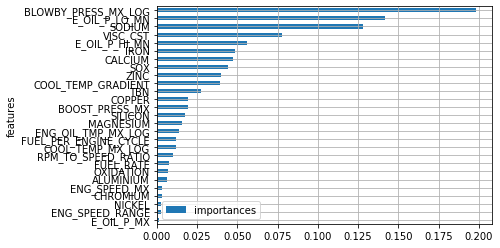

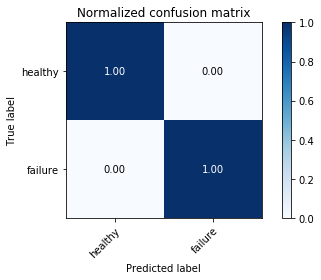

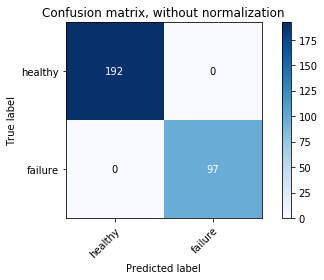

False Positive: 0.0
False Negative: 0.0
Accuracy: 0.9803750254427029
Result summary: 
        count       min  percentile_10  percentile_25      mean    median  \
y_true                                                                      
0         192  0.561231       0.908826       0.969773  0.965313  0.990000   
1          97  0.000000       0.003062       0.010769  0.068984  0.038676   

        percentile_75  percentile_90       max       std  
y_true                                                    
0            0.998917       1.000000  1.000000  0.068129  
1            0.110460       0.170666  0.397365  0.078108  


In [30]:
# randomly sample 18% of fmc healthy data
fmc_healthy = vhms_x_pap_dataset[(vhms_x_pap_dataset['failure']==0) & 
                                  (vhms_x_pap_dataset['CONTRACT']=='FMC')
                                ].sample(frac=fmc_healthy_frac)

# and randomly sample 4.3% of non-fmc healthy data
nonfmc_healthy = vhms_x_pap_dataset[(vhms_x_pap_dataset['failure']==0) & 
                                     (vhms_x_pap_dataset['CONTRACT']=='NON-FMC')
                                   ].sample(frac=nonfmc_healthy_frac)

# combine fmc and non-fmc healthy data with failure data
vhms_x_pap_dataset_resample = pd.concat([fmc_healthy, 
                                   nonfmc_healthy, 
                                   vhms_x_pap_dataset[vhms_x_pap_dataset['failure']==1]
                                  ])

health_score_model_with_pap = RFC(n_estimators=100, min_samples_split=10)
X = vhms_x_pap_dataset_resample[list(final_features)+pap_features]
y = vhms_x_pap_dataset_resample['failure']

with_pap_result = train_classifier_model(health_score_model_with_pap, X, y, test_size=0.33, random_state=42)
analyze_model_performance(with_pap_result)

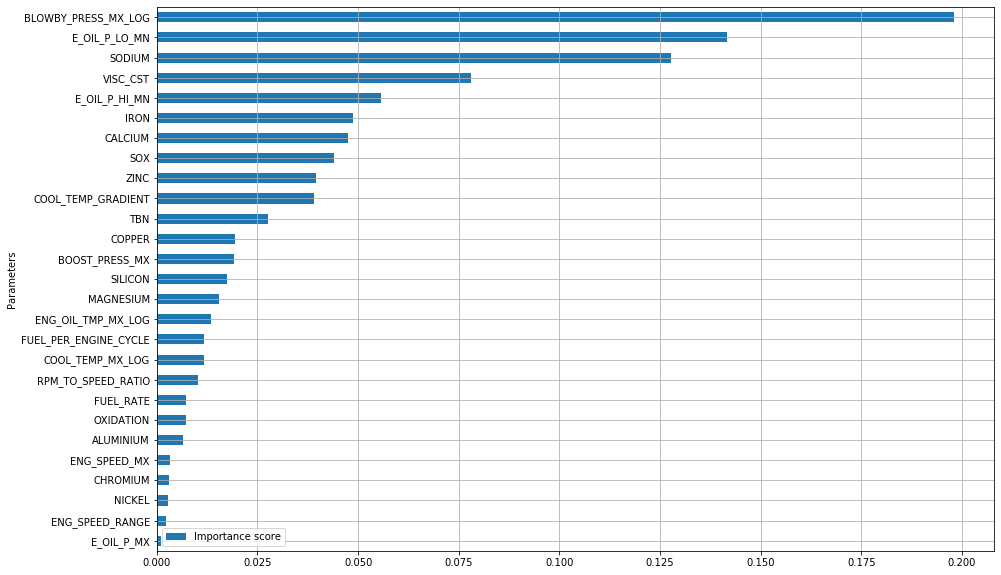

In [31]:
pd.DataFrame({
    "Parameters": list(final_features)+pap_features,
    "Importance score": health_score_model_with_pap.feature_importances_
}).sort_values('Importance score').set_index("Parameters").plot(kind="barh", figsize=(15,10), grid=True)

## Build Model Without PAP

We only get few records that have PAP match. So we will try to build two models, without adn with PAP and compare both results. This section is for the second approach

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


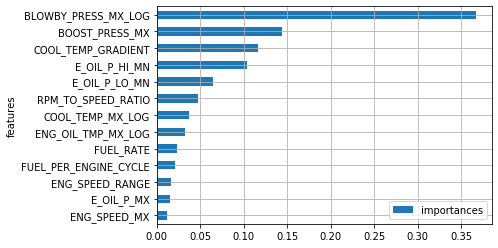

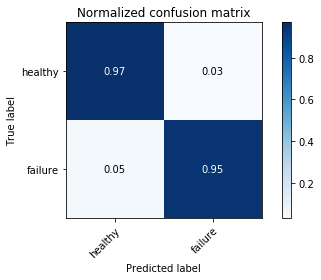

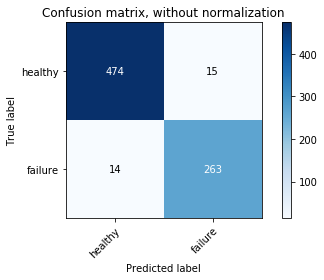

False Positive: 0.05054151624548736
False Negative: 0.03067484662576687
Accuracy: 0.9577325539995252
Result summary: 
        count       min  percentile_10  percentile_25      mean    median  \
y_true                                                                      
0         489  0.142818       0.728051       0.899685  0.912163  0.977423   
1         277  0.000000       0.010448       0.025111  0.140803  0.077028   

        percentile_75  percentile_90      max       std  
y_true                                                   
0            0.996667       1.000000  1.00000  0.148170  
1            0.189016       0.332987  0.94202  0.167083  


In [32]:
# randomly sample 18% of fmc healthy data
# randomly sample 18% of fmc healthy data
fmc_healthy = vhms_x_info_dataset[(vhms_x_info_dataset['failure']==0) & 
                                  (vhms_x_info_dataset['CONTRACT']=='FMC')
                                 ].sample(frac=fmc_healthy_frac)

# and randomly sample 4.3% of non-fmc healthy data
nonfmc_healthy = vhms_x_info_dataset[(vhms_x_info_dataset['failure']==0) & 
                                     (vhms_x_info_dataset['CONTRACT']=='NON-FMC')
                                    ].sample(frac=nonfmc_healthy_frac)

# combine fmc and non-fmc healthy data with failure data
vhms_dataset_resample = pd.concat([fmc_healthy, 
                                   nonfmc_healthy, 
                                   vhms_x_info_dataset[vhms_x_info_dataset['failure']==1]
                                  ])

health_score_model_without_pap = RFC(n_estimators=100, min_samples_split=10)
X = vhms_dataset_resample[final_features]
y = vhms_dataset_resample['failure']

without_pap_result = train_classifier_model(health_score_model_without_pap, X, y, test_size=0.333, random_state=42)
analyze_model_performance(without_pap_result)

### Accuracy on Discarded Data (All Healthy)

In [33]:
discarded = vhms_dataset.loc[[i for i in vhms_dataset.index if i not in vhms_dataset_resample.index]]
X_discarded = discarded[final_features]
y_discarded = discarded['failure']
y_pred = health_score_model_without_pap.predict(X_discarded)
health_score = health_score_model_without_pap.predict_proba(X_discarded)
print("Accuracy: ", np.sum(y_discarded==y_pred)/len(y_discarded))
print("Average HS: ", np.mean(health_score[:,0]))
print("Median HS: ", np.median(health_score[:,0]))
print("Standard Deviation HS: ", np.std(health_score[:,0]))

Accuracy:  0.9880681818181818
Average HS:  0.750083549731948
Median HS:  0.9640124777183601
Standard Deviation HS:  0.36981967581974085


# Fit scoring pipeline to be used in scoring script

In [34]:
vhms_scoring_cleaning_pipe = Pipeline([
    ('ensure-numeric-datatypes', EnsureDataTypes(['SMR']+primary_features)),
    ('sensor-error-handling', VHMSReplaceSensorErrorValue(primary_features)),
    ('features-derivator', DeriveFeatures([engine_hd785_feature_derivator]))
]).fit(vhms_trend_hd785_selected.copy())

pap_scoring_cleaning_pipe = Pipeline([
    ('ensure-numeric-datatypes', EnsureDataTypes(['HRS_KM_TOT', 'HRS_KM_OC']+pap_features)),
    ('pap-data-cleaner', PapOilDataCleanser(unit_model='HD785-7', component='ENGINE', features=pap_features)),
    ('pap-imputer', PapOilImputation(unit_model='HD785-7', component='ENGINE', features=pap_features))
]).fit(pap_oil.copy())

model_route = [
    (True, health_score_model_with_pap, final_features+pap_features),
    (False, health_score_model_without_pap, final_features)]

scoring_standard_scaler = DfStandardScaler(final_features+primary_features+pap_features)
health_scoring_pipe = Pipeline([
    ('standard-scaler', scoring_standard_scaler),
    ('inverse-standard-scaller', InverseTransfromStandardScaller(scoring_standard_scaler)),
    ('ensure-numeric-datatypes', EnsureDataTypes(final_features+pap_features)),
    ('model-router', HealthScoreModelRouter(flag_columns='with_pap', routes=model_route))
]).fit(vhms_x_pap_dataset[vhms_x_pap_dataset['failure']==0].copy())

2019-09-10 10:18:04: Fitting sensor error scaler with data
	2019-09-10 10:18:04: Separate sensor value from mean calculation
	2019-09-10 10:18:04: Computing average value of each equipment
	2019-09-10 10:18:20: Computing average value of all equipment
	2019-09-10 10:18:20: Finish fitting scaler
2019-09-10 10:18:20: Transforming data
	2019-09-10 10:18:20: Replacing error value with average for each serial number
2019-09-10 10:18:22: Fitting Oil Analyisis data for references


In [44]:
joblib.dump(vhms_scoring_cleaning_pipe, 'model/hd785-7_engine_vhms_prep_pipe.pkl')
joblib.dump(pap_scoring_cleaning_pipe, 'model/hd785-7_engine_pap_prep_pipe.pkl')
joblib.dump(health_scoring_pipe, 'model/hd785-7_engine_health_scoring_pipe.pkl')

['model/hd785-7_engine_health_scoring_pipe.pkl']

# ----------------------- Training script end here -----------------------

# Scoring Script

json_body_for_handle_request = {
    vhms: [
        {
            param1: value1,
            param2: value2,
            paramN: valueN  
        }, 
        {
            param1: value1,
            param2: value2,
            paramN: valueN
        }, 
        {
            param1: value1,
            param2: value2,
            paramN: valueN
        }, 
        {
            param1: value1,
            param2: value2,
            paramN: valueN
        }
    ],
    pap: [
       {
            param1: value1,
            param2: value2,
            paramN: valueN  
        }, 
        {
            param1: value1,
            param2: value2,
            paramN: valueN
        }, 
        {
            param1: value1,
            param2: value2,
            paramN: valueN
        }, 
        {
            param1: value1,
            param2: value2,
            paramN: valueN
        }
    ]
}

json_body_for_handle_request = {
    vhms: {
        param1: value1,
        param2: value2,
        paramN: valueN
    },
    pap: {
        param1: value1,
        param2: value2,
        paramN: valueN
    }
}

 # Prepare Json Input Data

In [42]:
vhms_sample = vhms_trend_hd785[vhms_trend_hd785['UNIT_SRL_NUM']=='30025'].reset_index(drop=True)
print(len(vhms_sample))
pap_data = []
for idx in sample.index:
    vhms = sample.loc[idx]
    pap = get_match_pap(pap_oil, 
                        srl_num=vhms.get('UNIT_SRL_NUM'),
                        date=str(vhms.get('TIMESTAMP')),
                        component='ENGINE')[['LAB_NUM','MODL_NUM', 'SRL_NUM', 'SAMPL_DT','HRS_KM_TOT', 'HRS_KM_OC', 'COMPONENT']+pap_features]
    pap_data.append(pap)
pap_data = pd.concat(pap_data).drop_duplicates().reset_index(drop=True)

vhms = from_pandas_to_json(sample)
pap = from_pandas_to_json(pap_data)
data = {"unit_model": "HD785-7", "component": "engine", "vhms": vhms, "pap":pap}
write_data_to_json(data, "sample_data_input_hd785_allrecords.json")

1100


# Visualise Health Score Trend

In [39]:
hist_comp_repl[(hist_comp_repl['MODL_UNIT']=='HD785-7') & (hist_comp_repl['COMPONENT']=='ENGINE ASSY')]

,Unnamed: 0,MODL_UNIT,CODE_UNIT,SRL_NUM,COMPONENT_GROUP,COMPONENT,REP_NUM,STATUS,BEG_HM,END_HM,LIFETIME_HOUR
172,172,HD785-7,DT4309,30032,ENGINE SYSTEM,ENGINE ASSY,1,SCH,0,31579,31579
174,174,HD785-7,DT4310,30036,ENGINE SYSTEM,ENGINE ASSY,1,SCH,0,14171,14171
175,175,HD785-7,HD1135,30141,ENGINE SYSTEM,ENGINE ASSY,1,USC,0,15610,15610
176,176,HD785-7,HD1135,30141,ENGINE SYSTEM,ENGINE ASSY,2,USC,15610,15663,53
177,177,HD785-7,HD1142,30148,ENGINE SYSTEM,ENGINE ASSY,1,SCH,0,23190,23190
178,178,HD785-7,HD1136,30151,ENGINE SYSTEM,ENGINE ASSY,1,SCH,0,30152,30152
179,179,HD785-7,HD1139,30155,ENGINE SYSTEM,ENGINE ASSY,1,USC,0,18270,18270
182,182,HD785-7,DT4361,30160,ENGINE SYSTEM,ENGINE ASSY,1,SCH,0,33092,33092
183,183,HD785-7,DT4362,30161,ENGINE SYSTEM,ENGINE ASSY,1,USC,0,25934,25934
184,184,HD785-7,DT4363,30164,ENGINE SYSTEM,ENGINE ASSY,1,SCH,0,30512,30512


In [45]:
vhms_pipe = joblib.load('model/hd785-7_engine_vhms_prep_pipe.pkl')
pap_pipe = joblib.load('model/hd785-7_engine_pap_prep_pipe.pkl')
hs_scoring_pipe = joblib.load('model/hd785-7_engine_health_scoring_pipe.pkl')

2019-09-10 10:18:51: Transforming data
	2019-09-10 10:18:51: Replacing error value with average for each serial number
index                                 2379
SRL_NUM                              30032
MODL_NUM                           HD785-7
ROOM                                DT4309
PLNT                                   BDI
SORT_FLD                               NaN
CUSTOMER_NAME        PAMAPERSADA NUSANTARA
CONTRACT                               FMC
LAST_UPDATED_DATE      2016-09-15 00:00:00
Name: 0, dtype: object
     REP_NUM STATUS  BEG_HM  END_HM  LIFETIME_HOUR
172        1    SCH       0   31579          31579


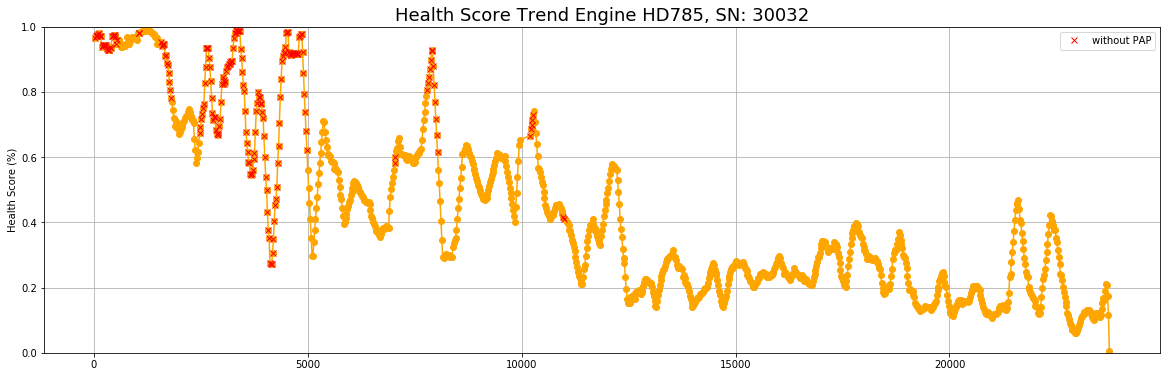

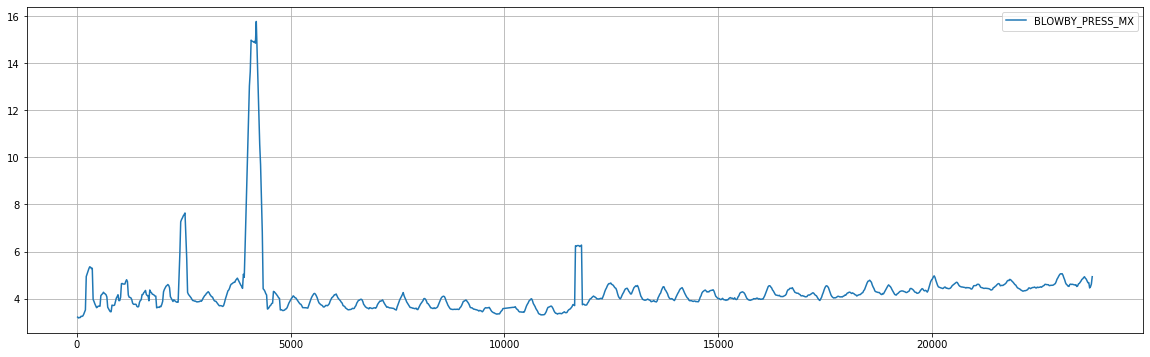

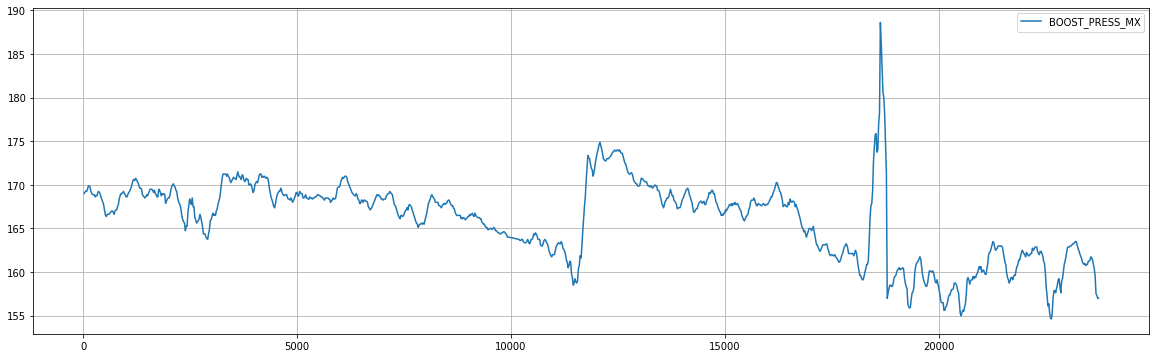

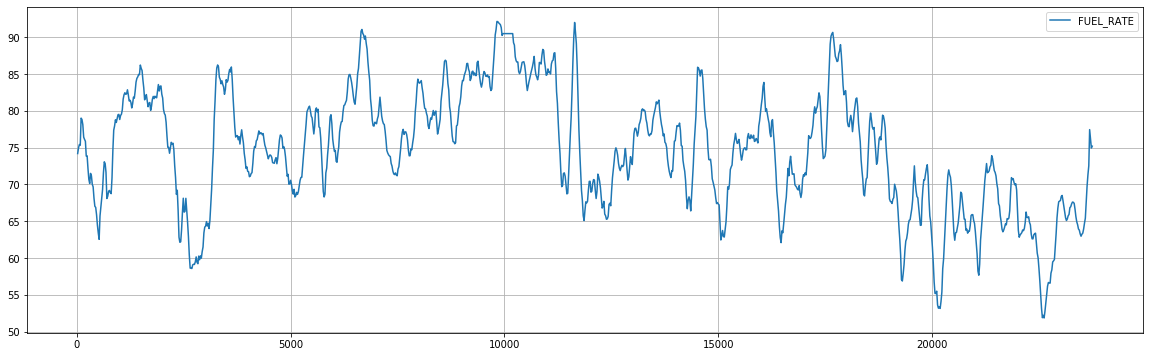

In [41]:
srl_num = '30032'
# vhms = vhms_pipe.transform(
#     vhms_trend_hd785_selected[vhms_trend_hd785_selected['UNIT_SRL_NUM']==srl_num].copy())

vhms_kpp = vhms_trend_hd785[vhms_trend_hd785['UNIT_SRL_NUM']==srl_num]
# vhms_kpp['FUEL_RATE'] = 12#vhms_kpp['FUEL_RATE'].max()
vhms = vhms_pipe.transform(
    vhms_kpp.copy())
vhms['UNIT_MODL'] = 'HD785-7'

pap = pap_pipe.transform(
    pap_oil[pap_oil['SRL_NUM']==srl_num].copy())

scoring_dataset = join_vhms_with_pap(vhms, pap, time_window=30)
scoring_dataset['with_pap'] = scoring_dataset['LAB_NUM'].map(lambda x: True if x is not None and x==x else False)

hs_result = hs_scoring_pipe.transform(scoring_dataset)
hs = hs_result[:,0].astype(np.double)

plt.figure(figsize=(20,6))
smoothing_window = 7
smoothing_window_param = 5
scoring_dataset['health_score'] = make_smooth(hs,window_size=smoothing_window)
# scoring_dataset['health_score'] = scoring_dataset['health_score'].apply(lambda x: x*1.2)
# scoring_dataset['health_score'] = scoring_dataset['health_score'].apply(lambda x: 1 if x>1 else x)

# print equipment info
equipment_info = unit_population_latest[
    (unit_population_latest['SRL_NUM']==srl_num) & (unit_population_latest['MODL_NUM']=='HD785-7')].reset_index().loc[0]
print(equipment_info)

hist = hist_comp_repl[(hist_comp_repl['SRL_NUM']==srl_num) & 
                      (hist_comp_repl['COMPONENT']=="ENGINE ASSY")][
    ["REP_NUM", "STATUS", "BEG_HM", "END_HM", "LIFETIME_HOUR"]]
print(hist)

#plot
without_pap_index = scoring_dataset[scoring_dataset['with_pap']==False].index
plt.plot(scoring_dataset['SMR'],  scoring_dataset['health_score'], "o-",
         label="", color="orange")
plt.plot(scoring_dataset.loc[without_pap_index, 'SMR'], 
         scoring_dataset.loc[without_pap_index, 'health_score'], 'x', 
         label='without PAP', color='red', alpha=1)
plt.ylim([0,1])
plt.ylabel('Health Score (%)')
plt.title('Health Score Trend Engine HD785, SN: {}'.format(srl_num), size=18)
plt.grid()
plt.legend()
plt.show()

param = ["BLOWBY_PRESS_MX", "BOOST_PRESS_MX", "FUEL_RATE"]
for p in param:
    plt.figure(figsize=(20,6))
    y = scoring_dataset[p].values
    plt.plot(scoring_dataset['SMR'], make_smooth(y, window_size=smoothing_window_param), label=p)
    plt.grid()
    plt.legend()
    plt.show()



# ------------------------------------------ End of script --------------------------------------------

with_pap_df = scoring_dataset[(scoring_dataset['SMR']>=0) & (scoring_dataset['SMR']<20000)][
    ['SMR', 'TIMESTAMP', 'with_pap']].sort_values("SMR")
with_pap_df['with_pap'] = with_pap_df['with_pap'].map(lambda x: int(x==True))
with_pap = with_pap_df['with_pap'].values
pap_spectrum = np.empty([100, len(with_pap)])
pap_spectrum[:] = with_pap

fig, ax = plt.subplots(figsize=(15,10))
smr = with_pap_df['SMR'].tolist()
extent = (min(smr), max(smr), min(smr)/6, max(smr)/6)
ax.imshow(pap_spectrum, extent=extent, cmap='Pastel1')
ax.set_xticks(np.arange(min(smr), max(smr)+1, 1000.0))
ax.set_yticks([])
ax.set_xlabel("SMR (Hours)", size=14)
plt.show()

xticks

x = np.array([1,2,3])
bigger = np.empty([10,3])
bigger[:] = x
bigger

## Generate Health Score Dataset (For RUL Regression)

health_score_collection = []
for i, srl_num in enumerate(srl_num_passed):
    vhms_kpp = vhms_trend_hd785[vhms_trend_hd785['UNIT_SRL_NUM']==srl_num]
    if len(vhms_kpp) > 100:
        vhms = vhms_pipe.transform(vhms_kpp.copy())
        vhms['UNIT_MODL'] = 'HD785-7'

        pap = pap_pipe.transform(
            pap_oil[pap_oil['SRL_NUM']==srl_num].copy())

        scoring_dataset = join_vhms_with_pap(vhms, pap, time_window=30)
        scoring_dataset['with_pap'] = scoring_dataset['LAB_NUM'].map(lambda x: True if x is not None and x==x else False)

        hs_result = hs_scoring_pipe.transform(scoring_dataset)
        hs = hs_result[:,0].astype(np.double)

        smoothing_window = 5
        smoothing_window_param = 3
        scoring_dataset['health_score'] = make_smooth(hs,window_size=smoothing_window)
        health_score_collection.append(scoring_dataset)
        
        print("Finish {0} of {1}, serial number: {2} is saved".format(i+1, len(srl_num_passed), srl_num))
    else:
        print("Finish {0} of {1}, serial number: {2} si discarded".format(i+1, len(srl_num_passed), srl_num))

health_score_dataset = pd.concat(health_score_collection)
fn = 'hd785_engine_healthscore_dataset.csv'
health_score_dataset.to_csv(fn, index=False)
print("Saved {0} records health score dataset to {1}".format(len(health_score_dataset), fn))

## ----------- end here -------------